# Minimum of PES for H2O @ Mn (II) on AWS-DM1

We evaluate VQE on the AWS-DM1 remote simulator for system $H_2O @ Mn(II)$. We use pennylane for this purpose and it has pennylane-braket-plugin. AWS-DM1 device can simulate upto 17 qubits but here we only use 4.

We tried on run on the real hardware (Rigetti- Aspen 3) but the device went to maintenance mode during the execution. Therefore we present the results with simulator.

In [12]:
import sys
sys.path.append('..')

In [13]:
import pickle 
import pennylane as qml
import pennylane.numpy as np
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from utils import rel_err

## Hamiltonian construction

In [14]:
with open('hamiltonian.pickle', 'rb') as handle:
    h_dict = pickle.load(handle)

In [15]:
ops = []

for op in h_dict['ops']:
    ops.append(qml.pauli.string_to_pauli_word(op))

coeffs = []
for coeff in h_dict['coeffs']:
    coeffs.append(coeff)

H = qml.Hamiltonian(coeffs, ops)
H.compute_grouping()

In [42]:
len(H.ops)

58

## Simulation on default.qubit

In [16]:
qubits = 4
dev = qml.device("default.qubit", wires=qubits)

In [32]:
@qml.qnode(dev)
def cost_fn(param):
    qml.BasisState(np.array([1,0,0,1]), wires=range(qubits))
    
    for q in range(qubits):
        qml.RY(param[q][0], q)
    
    for q in range(qubits - 1):
        qml.CNOT((q, q+1))
    
    for q in range(qubits):
        qml.RY(param[q][1], q)
        
    return qml.expval(H)

In [34]:
# Define a simple callback function
exact_energy = -663.963762563311
active_space_part = -620.331186717815
nuc_rep = 69.424951352255

intermediate_info = []
five_percent = []
one_percent = []

def callback(value):
    intermediate_info.append(value)
    five_percent.append(exact_energy*(1-0.05))
    one_percent.append(exact_energy*(1-0.01))
    clear_output(wait=True)
    plt.plot(intermediate_info, color='purple', lw=2, label=f'Simulated VQE {np.round(value,4)}')
    plt.ylabel('Energy')
    plt.xlabel('Iterations')
    # Exact ground state energy value
    plt.axhline(y=exact_energy,color="tab:red",ls="--", lw=2,label="Target: "+str(np.round(exact_energy,4)))
    plt.plot(five_percent, lw=1, label=f'5% ({np.round(exact_energy*(1-0.05),4)})')
    plt.plot(one_percent, lw=1, label=f'1% ({np.round(exact_energy*(1-0.01),4)})')
    plt.legend()
    plt.grid()
    plt.show()

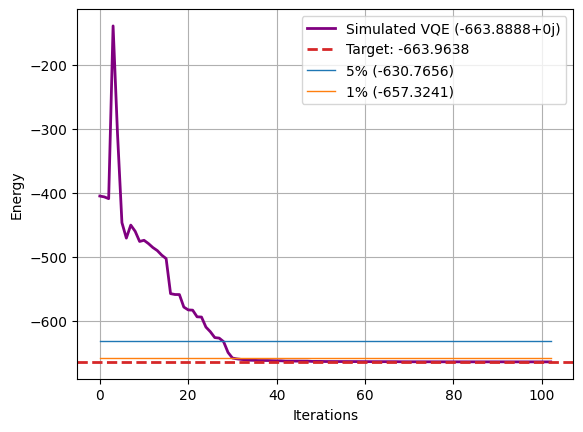


Final value of the ground-state energy = -663.88901032+0.00000000j Ha


In [33]:
max_iterations = 100
opt = qml.SPSAOptimizer(maxiter=max_iterations,a = 0.01, c = 0.01, A = 1)
theta = np.array(np.random.uniform(size=(4,2)), requires_grad=True)

# store the values of the cost function
energy = [cost_fn(theta)]

conv_tol = 1e-06

for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)
    callback(prev_energy)
    energy.append(cost_fn(theta))
    conv = np.abs(energy[-1] - prev_energy)
    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")

In [35]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(exact_energy, energy[-1])

print(f'Expected ground state energy: {exact_energy:.12f}')
print(f'Computed ground state energy: {energy[-1]:.12f}')
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -663.963762563311
Computed ground state energy: -663.889010318529+0.000000000000j
Relative error: 0.000112584826


In [36]:
theta

tensor([[ 4.68503681+0.j,  1.59585699+0.j],
        [ 1.56915025+0.j, -1.56700956+0.j],
        [ 1.57492611+0.j,  1.49190881+0.j],
        [ 1.57125203+0.j, -1.57032049+0.j]], requires_grad=True)

## Deparameterisation

In [37]:
def cost_fn_deparam(param):
    qml.BasisState(np.array([1,0,0,1]), wires=range(qubits))
    
    qml.RY(param[0], 0)
    qml.RY(np.pi/2, 1)
    qml.RY(np.pi/2, 2)
    qml.RY(np.pi/2, 3)
    
    for q in range(qubits - 1):
        qml.CNOT((q, q+1))
    
    qml.RY(np.pi/2, 0)
    qml.RY(-np.pi/2, 1)
    qml.RY(param[1], 2)
    qml.RY(-np.pi/2, 3)
        
    return qml.expval(H)

In [38]:
dev = qml.device('default.qubit', wires = qubits)
cost_fn_deparam_local = qml.QNode(cost_fn_deparam, device = dev, diff_method = 'parameter-shift')
cost_fn_deparam_local

<QNode: wires=4, device='default.qubit', interface='autograd', diff_method='parameter-shift'>

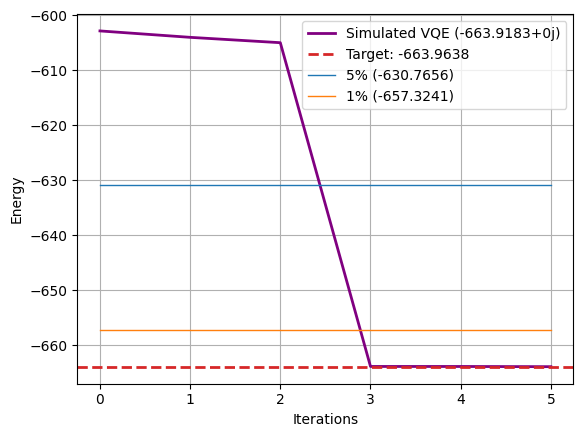


Final value of the ground-state energy = -663.918311705774 Ha


In [40]:
max_iterations = 3
opt = qml.SPSAOptimizer(maxiter=max_iterations,a = 0.01, c = 0.01, A = 1)

initial_point = [4.68503681, 1.49190881]
theta_deparam = np.array(initial_point, requires_grad=True)

# store the values of the cost function
for n in range(max_iterations):
    theta_deparam, prev_energy = opt.step_and_cost(cost_fn_deparam_local, theta_deparam)
    callback(prev_energy)

computed_energy = prev_energy.real
print("\n" f"Final value of the ground-state energy = {computed_energy:.12f} Ha")

In [41]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(exact_energy, computed_energy)

print(f'Expected ground state energy: {exact_energy:.12f}')
print(f'Computed ground state energy: {computed_energy:.12f}')
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -663.963762563311
Computed ground state energy: -663.918311705774
Relative error: 0.000068453822


In [43]:
theta_deparam

tensor([4.70255747+0.j, 1.52097068+0.j], requires_grad=True)

## Simulation on default.mixed device with ZNE error mitigation

In [90]:
def _cost_fn_deparam(param):
    qml.PauliX(0)
    qml.PauliX(3)
    
    qml.RY(param[0], 0)
    qml.RY(np.pi/2, 1)
    qml.RY(np.pi/2, 2)
    qml.RY(np.pi/2, 3)
    
    for q in range(qubits - 1):
        qml.CNOT((q, q+1))
    
    qml.RY(np.pi/2, 0)
    qml.RY(-np.pi/2, 1)
    qml.RY(param[1], 2)
    qml.RY(-np.pi/2, 3)
        
    return qml.expval(H)

In [91]:
# Describe noise
noise_gate = qml.DepolarizingChannel
noise_strength = 0.05

# Load devices
dev_ideal = qml.device("default.mixed", wires=qubits)
dev_noisy = qml.transforms.insert(noise_gate, noise_strength, position="all")(dev_ideal)

qnode_noisy = qml.QNode(_cost_fn_deparam, dev_noisy)
qnode_ideal = qml.QNode(_cost_fn_deparam, dev_ideal)

In [92]:
print(qml.draw(qnode_ideal)((theta_deparam)))

0: ──X─────────RY(4.70+0.00j)─╭●──RY(1.57)────────────────────────────┤ ╭<𝓗>
1: ──RY(1.57)─────────────────╰X─╭●─────────RY(-1.57)─────────────────┤ ├<𝓗>
2: ──RY(1.57)────────────────────╰X────────╭●──────────RY(1.52+0.00j)─┤ ├<𝓗>
3: ──X─────────RY(1.57)────────────────────╰X──────────RY(-1.57)──────┤ ╰<𝓗>


In [93]:
from pennylane.transforms import mitigate_with_zne

scale_factors = [1, 2, 3]

qnode_mitigated = mitigate_with_zne(
    scale_factors=scale_factors,
    folding=qml.transforms.fold_global,
    extrapolate=qml.transforms.richardson_extrapolate,
)(qnode_noisy)

print("Ideal QNode: ", qnode_ideal(theta_deparam.real))
print("Mitigated QNode: ", qnode_mitigated(theta_deparam.real))
print("Noisy QNode: ", qnode_noisy(theta_deparam.real))

Ideal QNode:  (-663.9333772852692+0j)
Mitigated QNode:  (-675.5906023363998+0j)
Noisy QNode:  (-576.9856684563911+0j)


## The Remote Braket Simulator

We use the optimal parameters obtained from the deparameterisation as the initial point and execute the circuit on the DM1 simulator.

In [94]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
tracker = Tracker().start()

In [100]:
device_arn = 'arn:aws:braket:::device/quantum-simulator/amazon/dm1'

In [101]:
dev = qml.device('braket.aws.qubit', device_arn=device_arn, wires=qubits)
cost_fn_braket_remote = qml.QNode(_cost_fn_deparam, device=dev)
cost_fn_braket_remote

<QNode: wires=4, device='braket.aws.qubit', interface='autograd', diff_method='best'>

In [102]:
scale_factors = [1, 2, 3]

qnode_mitigated = mitigate_with_zne(
    scale_factors=scale_factors,
    folding=qml.transforms.fold_global,
    extrapolate=qml.transforms.richardson_extrapolate,
)(cost_fn_braket_remote)

In [103]:
computed_energy = qnode_mitigated(theta_deparam.real)
print("\n" f"Final value of the ground-state energy = {computed_energy:.12f} Ha")


Final value of the ground-state energy = -663.933377285235+0.000000000000j Ha


In [106]:
tracker.stop()

In [111]:
tracker.simulator_tasks_cost()

Decimal('0.1462500000')

In [112]:
tracker.qpu_tasks_cost()

Decimal('9.1000000000')

In [113]:
tracker.quantum_tasks_statistics()

{'arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3': {'shots': 15000,
  'tasks': {'COMPLETED': 14, 'CANCELLED': 1}},
 'arn:aws:braket:::device/quantum-simulator/amazon/dm1': {'shots': 0,
  'tasks': {'COMPLETED': 39},
  'execution_duration': datetime.timedelta(seconds=1, microseconds=439000),
  'billed_execution_duration': datetime.timedelta(seconds=117)}}

In [114]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(exact_energy, computed_energy)

print(f'Expected ground state energy: {exact_energy:.12f}')
print(f'Computed ground state energy: {computed_energy:.12f}')
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -663.963762563311
Computed ground state energy: -663.933377285235+0.000000000000j
Relative error: 0.000045763458


In [116]:
total_energy = computed_energy + active_space_part + nuc_rep

actual_energy = -33353.561832
ev = 27.2114

print(f'Actual total energy: {actual_energy:.12f} Ha\n')
print(f"Total energy: {total_energy:.12f} Ha")
print(f"Total energy in ev: {total_energy*ev:.12f} ev\n")

rel_error = rel_err(actual_energy, total_energy*ev)
print(f'Relative error: {rel_error:.12f}')

Actual total energy: -33353.561831999999 Ha

Total energy: -1214.839612650795+0.000000000000j Ha
Total energy in ev: -33057.486635685855+0.000000000000j ev

Relative error: 0.008876868917


## Results

The circuit execution takes ~117 seconds with a relative error within $10^{-4}$ Hartree.

The relative error of `VQE's ground state energy` with the `classical reference solution` is within $10^{-2}$ Hartree.

## Summary

The work demonstrates the application of quantum computing methods to find the minimum of the Potential Energy Surface (PES). Based on the recent paper Molecular Energy Landscapes of Hardware-Efficient Ansätze in Quantum Computing by Boy Choy and David J. Wales, we used a deparameterisation approach to freeze $R_y$ gates with standardized parameter values which helped in simplifying the energy landscape while maintaining the accuracy of the global minimum.

We extended the deparameterisation procdeure to carbon capture on MOFs and explored the minimum of PES with $H_2O @ Mn(II)$ which led to interesting results. Through active space reduction, we simulated the ansatz with 4 qubits and achieved a relative error of $10^{-2}$ Ha with ideal simulation and $10^{-1}$ Ha with noisy simulation. We simulated our ansatzes on noisy simulators as well as Braket's remote simulator and obtained promising results. We employed error mitigation techniques in noisy simulators which converged the ground state energy to within 4.6 percent of the acutal.